# Minimal 2D Pytorch Graph SLAM

This notebook presents a minimal example of graph-based Simultaneous Localisation and Mapping (SLAM) in 2D using Pytorch. It accompanies the introduction to optimisation-based SLAM in my course on autonomous system in UAS Technikum's Master Robotics Engineering program.

First, we create some test data as a list of $(x, y, \theta)$ positions without any noise. This represents the ground truth. From the ground truth, incremental transforms are calculated and pertubed to simulate process noise.

In [ ]:
import numpy.typing as npt
import numpy as np
import open3d as o3d # type: ignore
import torch # type: ignore
import torch.optim as optim # type: ignore

## GENERATE TRUE TESTDATA, error should go towards 0 with shrinking noise
# Orientations are set to 0 as they are not considered (for simplicity)
truePos = np.array([
    [0, 0, 0],
    [1.5, 1, 0],
    [2.5, 2, 0],
    [2, 4.5, 0],
    [3, 3.5, 0],
    [4, 2.5, 0],
    [5, 1.5, 0],
])

# Create transformations with random noise
transformations = []
for i, item in enumerate(truePos[:-1]):
    transformations.append(truePos[i+1] - item)
transformations = np.array(transformations)
transformations *= np.ones_like(transformations) + (np.random.rand(*transformations.shape)-0.5)*0.5

This graph formulation introduces virtual measurements each associated with a voxel/submap. The result is a graph where each node has a maximum of two neighbours and one virtual measurement.

The notation here is consistent with the lecture slides. $x_{ij}$ depicts a relative transform from node $i$ to $j$. $z_i$ is a virtual measurement between node $i$ and its corresponding voxel.

# <img src="material/pytorch_pgo_example.png" style="max-width: 800px;">
 
For the example, measurements are created artificially from ground truth positions and perturbed using measurement noise. It is important here, that measurements and transforms from earlier are perturbed individually from the ground truth positions. Otherwise, we would introduce artificial correlation between process and measurement error.

In [ ]:
## Quick array checking
def checkPoint(point: np.ndarray) -> None:
    """Checks array shape of singular point """
    assert point.shape == (3,)

def checkPoints(points: np.ndarray) -> None:
    """Checks array shape of a list of points """
    assert points.shape[1] == 3
    assert points.shape[0] > 0

## GRAPH SLAM Frontend
#transformations: xi to xi+1 (dx, dy, dz)
#measurements: zi = Oi to xi (dx, dy, dz)
#origins: Oi (x, y, z) in world coordinates

voxelSize = 1.0
origin = -voxelSize/2
voxelgrid = o3d.geometry.VoxelGrid.create_dense(
    np.array([origin, origin, origin]), # origin
    np.array([0.,0.,0.]), # colour
    voxelSize, # voxel size in # m
    20, 20, 20 # width, height, depth
)

def getVoxelOrigin(point, voxelgrid) -> np.ndarray:
    """Returns nearest voxel origin (= offset index to centre of voxel)"""
    checkPoint(point)
    return voxelgrid.get_voxel(point)*voxelgrid.voxel_size

# Determine origins of encountered nodes
predictedPos = np.cumsum(transformations, axis=0)
origins = np.array([ getVoxelOrigin(item, voxelgrid) for item in predictedPos ])
measurements = np.array([ pos - origin for origin, pos in zip(origins, truePos) ])

## Measurement noise
measurements *= np.ones_like(measurements) + (np.random.rand(*measurements.shape)-0.5)*0.2

After virtual measurment extraction, error in the graph must be defined.

Error is propagated from a voxel origin through the corresponding virtual measurement, trhough the relative transform to a neighbouring node and to the neighbouring voxel's origin through the neighbouring virtual measurment. The resulting error function is simple in that it can only process one virtual measurement per node. Therefore, global constraints, such as loop closure, can not be considered.

The following formula depicts the error function. Similarly to before (and the slides) $x_{ij}$ are relative transforms between nodes, $z_i$ are virtual measurements, and $o_i$ are the voxel origin positions. 

$e = \Sigma_{n-1} \left( o_i + z_i + x_{i,(i+1)} - (o_{i+1} + z_{i+1}) \right )$

To optimise the graph, we first formulate the error function (=loss in machine learning terms). It depends on the transforms between nodes, virtual measurement and voxel origins. Each node's error is summed up as the mean squared error.

In [ ]:

## GRAPH SLAM Backend
def graphLoss(transformations, measurements, origins):
    """Calculates the mse error over predictions between neighbouring nodes and virtual landmark observations """
    ei = torch.zeros( (3*(len(transformations-1))) )
    for i, _ in enumerate(transformations[:-1]) :
        ei[3*i:3*i+3] = torch.square(
            origins[i] + measurements[i] + transformations[i] - origins[i+1] - measurements[i+1]
        )
        #print(ei[3*i:3*i+3]) # -> Enable to see individual errors
    return torch.mean(ei) # Return mean squared error -> adapted from graph slam tutorial paper

# Check frontend formatting
checkPoints(transformations); checkPoints(measurements); checkPoints(origins)

In order to optimise, we create torch tensors for the transforms, measurements and voxel origins. It is important here that transformTensor has the argument `requires_grad` set to true. This tells the optimiser, that the parameters in transformTensor can be changed, while all other parameters are static.

This highlights the point of graph SLAM. We want to find a graph configuration that minimises the error over all observed data. Therefore, the transform's parameters must be adjusted to reason over observations. However, we also find that all information provided to the SLAM, must be aggregated into the error function to be considered during optimisation.

Optimisation follows a classic Pytorch training loop. Error is calculated and backpropagated before taking an optimisation step. Learning rate is adjusted to result in a nice loss plot (see next section) for the lecture slides.

In [ ]:
# Create torch tensors and make transforms adjustable
transformTensor = torch.tensor(transformations, requires_grad=True)
measurementTensor = torch.tensor(measurements)
originTensor = torch.tensor(origins)

optimizer = optim.SGD([transformTensor], lr=0.7)

losses = [] # Track losses for plotting

## Optimize graph using stochastic gradient descent
for epoch in range(100):
    loss = graphLoss(transformTensor, measurementTensor, originTensor)
    losses.append(loss.tolist())
    
    # Backward pass
    optimizer.zero_grad()  # Zero the gradients to avoid accumulation
    loss.backward()        # Compute gradients
    
    # Update parameters
    optimizer.step()

# Reconstruct transforms to poses
np.cumsum(transformTensor.tolist(), axis=0)

# Optimised Graph Visualisation

The following section plots the graph configurations and loss functions for the lecture slides.

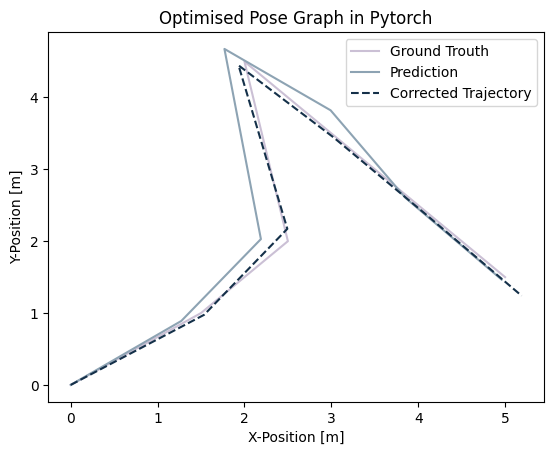

In [51]:
## Visualise for slides
%matplotlib inline
import matplotlib.pyplot as plt

colourScheme = {
    "darkblue": "#143049",
    "twblue": "#00649C",
    "lightblue": "#8DA3B3",
    "lightgrey": "#CBC0D5",
    "twgrey": "#72777A"
}

# Only plot position for clarity
gt_pos = truePos[:,:2]
pred_pos = predictedPos[:,:2]
corr_pos = np.cumsum(transformTensor.tolist(), axis=0)[:,:2]

# Add origin as initialisation for prettier plot
pred_pos = np.vstack([[0,0], pred_pos])
corr_pos = np.vstack([[0,0], corr_pos])

labels = ["Ground Trouth", "Prediction", "Corrected Trajectory"]
lines = ["solid", "solid", "dashed"]
colours = [colourScheme["lightgrey"], colourScheme["lightblue"], colourScheme["darkblue"]]

fig, ax = plt.subplots()
ax.plot(gt_pos[:,0], gt_pos[:,1], label=labels[0], c=colours[0], linestyle=lines[0])
ax.plot(pred_pos[:,0], pred_pos[:,1], label=labels[1], c=colours[1], linestyle=lines[1])
ax.plot(corr_pos[:,0], corr_pos[:,1], label=labels[2], c=colours[2], linestyle=lines[2])
ax.set_title("Optimised Pose Graph in Pytorch")
ax.set_xlabel("X-Position [m]")
ax.set_ylabel("Y-Position [m]")
ax.legend()

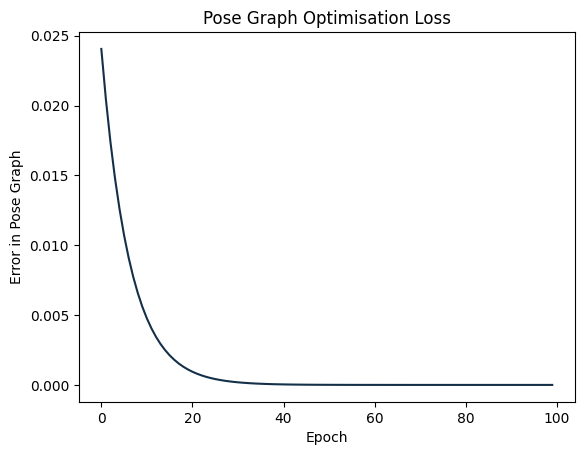

In [43]:
fig, ax = plt.subplots()
ax.set_title("Pose Graph Optimisation Loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Error in Pose Graph")
ax.plot(losses, c=colourScheme["darkblue"])